# Refine the Data

Create the items, users and interaction matrix

- **Items**: item id + metadata features
- **Users**: User id + metadata features
- **Interaction**: Explicit Matrix, Implicit Matrix

In [49]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
import pandas as pd
import re

## Items

For the items, we will keep the following:
- From `items_raw` dataframe
  - movie_id
  - title
  - year (release)
  - genre categories
- From `item_features` dataframe
  - overview
  - language (original_language)
  - runtime
  - vote_average
  - vote_count

In [2]:
items_raw = pd.read_csv("data/items_raw.csv")
item_features = pd.read_csv("data/item_features.csv")

*1. Get `year` from `release_title`* 

In [3]:
items_raw["release_date"] = pd.to_datetime(items_raw.release_date, infer_datetime_format=True)
items_raw["year"] = items_raw.release_date.apply(lambda x: str(x.year))

*2. Drop `imdb_url`,  `video_release_date` & `release_date`*

In [4]:
items_main = items_raw.drop(['video_release_date', 'release_date', 'imdb_url'], axis=1).copy()

In [5]:
# Match Whitespace + ( + YEAR + )
# regex_year = re.compile(r'\s\(\d{4}\)')
# items["movie"] = items.title.str.replace(regex_year, "")
# items["movie"] = items.movie.str.strip()

*3. Get the additional features from the item_features*

In [6]:
items_addtl = item_features[['overview', 'original_language', 'runtime', 'vote_average', 'vote_count', "movie_id"]].copy()

*4. Merge the two dataframes*

In [7]:
items = pd.merge(left=items_main, right=items_addtl, on="movie_id", how="left")

In [8]:
items.head()

,movie_id,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,SciFi,Thriller,War,Western,year,overview,original_language,runtime,vote_average,vote_count
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,1995,"Led by Woody, Andy's toys live happily in his ...",en,81.0,7.9,10878.0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,1,0,0,1995,James Bond must unmask the mysterious head of ...,en,130.0,6.8,2037.0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,1,0,0,1995,It's Ted the Bellhop's first night on the job....,en,98.0,6.1,1251.0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,1995,Chili Palmer is a Miami mobster who gets sent ...,en,105.0,6.5,501.0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,1,0,0,1995,An agoraphobic psychologist and a female detec...,en,124.0,6.5,424.0


In [9]:
items.overview.isna().sum()

18

In [10]:
items.overview.fillna("None", inplace=True)

### Getting the sentence vector

In [17]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [12]:
doc = nlp(items["overview"][0])

In [13]:
doc.vector

array([ 2.49380805e-02,  1.74549282e-01, -9.29457471e-02, -4.02068421e-02,
        2.45584920e-02,  2.10599136e-02,  4.59955782e-02, -1.43892854e-01,
        2.23628674e-02,  2.10939479e+00, -1.11910768e-01, -7.78442621e-02,
       -5.78953363e-02, -5.18039986e-02, -4.90232185e-02, -3.90546210e-02,
       -1.63908191e-02,  7.56938040e-01, -1.07308537e-01, -1.58448797e-02,
       -3.28326374e-02, -4.18951176e-02, -2.36957222e-02, -4.90324982e-02,
        3.45998853e-02, -5.01969596e-04, -7.33386278e-02,  8.14125240e-02,
        1.23276107e-03, -3.94272059e-02, -4.45753373e-02,  9.23748016e-02,
       -1.85925841e-01,  1.29784733e-01,  6.92790821e-02, -8.13476965e-02,
        3.25000323e-02,  8.13459679e-02, -4.94984947e-02, -1.00935347e-01,
        8.89295489e-02,  2.81169247e-02,  8.77274945e-03, -3.19957659e-02,
        7.94582665e-02,  9.91719663e-02, -1.07840024e-01, -5.39268330e-02,
       -3.52545083e-02,  1.26066720e-02,  3.39749381e-02, -7.42770284e-02,
       -5.82755692e-02, -

In [14]:
def word_vec(sentence):
    doc = nlp(sentence)
    return doc.vector

In [15]:
%%time
overview_embedding = items["overview"].apply(word_vec)

CPU times: user 23.7 s, sys: 19.6 ms, total: 23.7 s
Wall time: 23.7 s


In [18]:
overview_embedding = overview_embedding.to_list()

In [23]:
overview_embedding_list = []
for vec in overview_embedding:
    overview_embedding_list.append(vec.tolist())

In [29]:
len(overview_embedding_list)

1746

In [31]:
overview_embedding_df = pd.DataFrame(overview_embedding_list)

In [32]:
overview_embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.024938,0.174549,-0.092946,-0.040207,0.024558,0.021060,0.045996,-0.143893,0.022363,2.109395,...,-0.164214,0.073254,0.071066,0.005870,-0.047621,-0.005115,0.025926,-0.035420,-0.059641,-0.004321
1,-0.148743,0.054975,-0.012735,0.003243,-0.082071,-0.177124,-0.135892,0.036500,-0.000987,1.804925,...,-0.193255,0.056461,0.038040,-0.049742,-0.059125,0.078672,0.028826,0.006573,-0.070430,-0.000461
2,0.024798,0.201679,-0.035214,-0.044371,0.065224,0.011609,-0.008056,-0.141306,0.003372,2.377326,...,-0.125685,0.043005,0.087619,-0.073365,0.035089,-0.006726,-0.003821,-0.012937,-0.014347,0.046458
3,-0.044721,0.126973,-0.104857,-0.019217,0.138141,0.091052,0.026251,-0.202099,0.047526,2.029502,...,-0.125688,0.038220,0.011013,0.041688,0.000462,-0.014254,-0.015342,-0.110975,-0.009556,0.053125
4,0.080059,-0.017512,-0.176883,0.082077,0.056057,-0.022036,-0.042583,-0.109661,0.073444,2.139982,...,-0.184866,0.007139,0.070511,0.089315,0.028993,-0.071459,0.047445,-0.044927,-0.102735,-0.100472


In [34]:
items.columns

Index(['movie_id', 'title', 'genre_unknown', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'FilmNoir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'SciFi', 'Thriller', 'War', 'Western', 'year', 'overview',
       'original_language', 'runtime', 'vote_average', 'vote_count'],
      dtype='object')

In [44]:
item_similarity_df = pd.concat([
    items[['movie_id', 'genre_unknown', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'FilmNoir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'SciFi', 'Thriller', 'War', 'Western']], 
    overview_embedding_df],
    axis=1)

In [46]:
item_similarity_df.head()

,movie_id,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,290,291,292,293,294,295,296,297,298,299
0,1,0,0,0,1,1,1,0,0,0,...,-0.164214,0.073254,0.071066,0.005870,-0.047621,-0.005115,0.025926,-0.035420,-0.059641,-0.004321
1,2,0,1,1,0,0,0,0,0,0,...,-0.193255,0.056461,0.038040,-0.049742,-0.059125,0.078672,0.028826,0.006573,-0.070430,-0.000461
2,3,0,0,0,0,0,0,0,0,0,...,-0.125685,0.043005,0.087619,-0.073365,0.035089,-0.006726,-0.003821,-0.012937,-0.014347,0.046458
3,4,0,1,0,0,0,1,0,0,1,...,-0.125688,0.038220,0.011013,0.041688,0.000462,-0.014254,-0.015342,-0.110975,-0.009556,0.053125
4,5,0,0,0,0,0,0,1,0,1,...,-0.184866,0.007139,0.070511,0.089315,0.028993,-0.071459,0.047445,-0.044927,-0.102735,-0.100472


# Build nearest neighbor model

In [61]:
from reco.recommend import get_similar
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

In [76]:
%%time
item_distances, item_similar_indices = get_similar(overview_embedding_df, 5)

CPU times: user 1.25 s, sys: 70 µs, total: 1.25 s
Wall time: 1.25 s


In [77]:
item_similar_indices

array([[   0, 1215, 1417,  731, 1605],
       [   1,  228, 1604,  524,  196],
       [   2,  976,  494,  451, 1261],
       ...,
       [1742, 1472, 1743, 1473, 1215],
       [1744,  746, 1373,   47,   25],
       [1745,  975, 1646,  595, 1647]])

In [78]:
def show_similar(item_index, item_similar_indices):
        
    movie_ids = item_similar_indices[item_index]
    #movie_ids = item_encoder.inverse_transform(s)

    images = []
    for movie_id in movie_ids:
        img_path = 'data/posters/' + str(movie_id+1) + '.jpg'
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

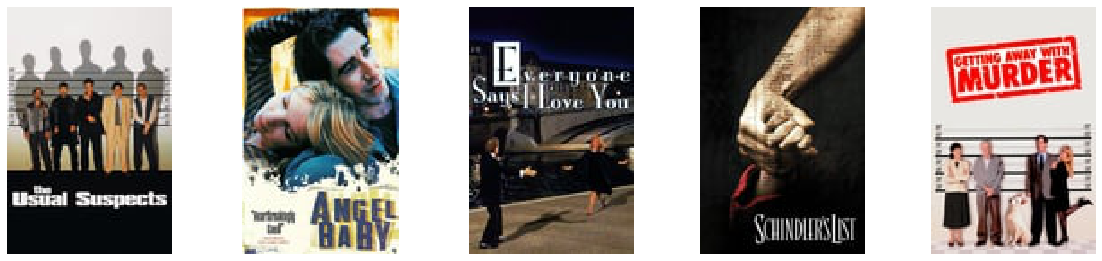

In [83]:
show_similar(11, item_similar_indices)